In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor 
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('final_df.csv')
df.shape

(178140, 31)

In [3]:
df.drop(columns='Unnamed: 0', inplace=True, axis=1)
df['time'] = pd.to_datetime(df['time'], utc=True)

### Setting time column as index

In [4]:
df = df.set_index('time')
df.index = pd.to_datetime(df.index)
df.sample(5)

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation other,generation other renewable,...,temp,temp_min,temp_max,wind_speed,weather_main,month,day,hour,year,quarter
time,,,,,,,,,,,,,,,,,,,,,
2017-01-29 12:00:00+00:00,359.0,873.0,4166.0,5188.0,233.0,1145.0,631.0,595.0,57.0,103.0,...,285.15,285.15,285.15,3,clouds,1,29,12,2017,1
2017-05-01 06:00:00+00:00,360.0,887.0,6376.0,6466.0,299.0,0.0,494.0,1764.0,61.0,103.0,...,284.15,284.15,284.15,1,clear,5,1,6,2017,2
2016-12-21 21:00:00+00:00,326.0,979.0,7414.0,6875.0,305.0,0.0,696.0,3790.0,56.0,106.0,...,283.15,283.15,283.15,1,clear,12,21,21,2016,4
2016-09-05 23:00:00+00:00,337.0,598.0,5052.0,4404.0,297.0,0.0,1182.0,1546.0,57.0,87.0,...,300.54,299.82,302.15,2,clear,9,5,23,2016,3
2018-09-30 11:00:00+00:00,374.0,724.0,3765.0,4019.0,235.0,0.0,645.0,2141.0,58.0,99.0,...,299.15,299.15,299.15,0,clear,9,30,11,2018,3


In [5]:
df.shape

(178140, 29)

## Splitting into train and test

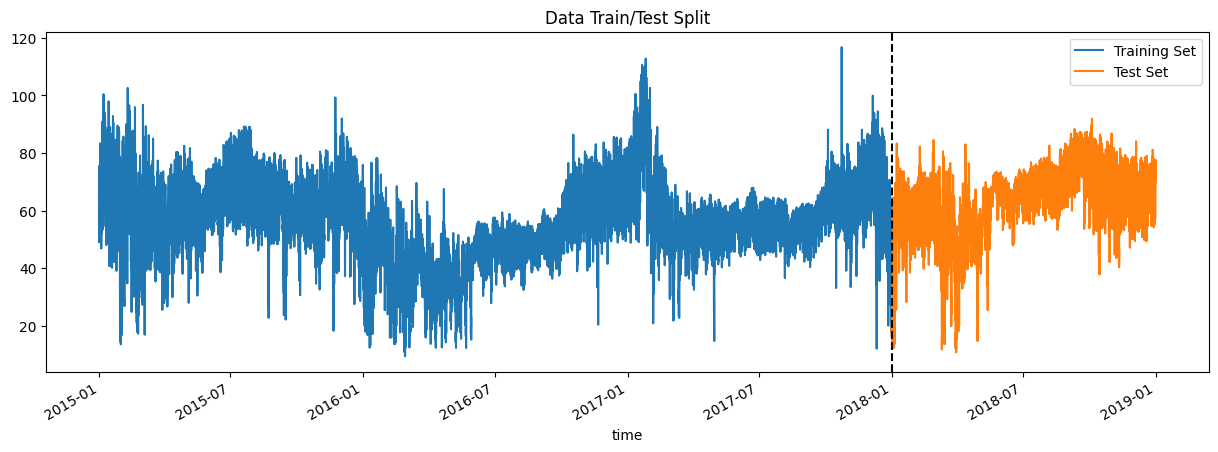

In [6]:
train_price = df.loc[df.index < '01-01-2018',  ['price actual']]
test_price = df.loc[df.index >= '01-01-2018', ['price actual']]

fig, ax = plt.subplots(figsize=(15, 5))
train_price.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test_price.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2018', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [7]:
X = df.drop(columns='price actual', axis=1)
y = df['price actual']

### Splitting the data into train test split 

In [8]:
X_train = X[X.index < '01-01-2018']
X_test = X[X.index >= '01-01-2018']
y_train = y[y.index < '01-01-2018']
y_test = y[y.index >= '01-01-2018']

In [9]:
X_train.shape, y_train.shape

((133077, 28), (133077,))

In [10]:
X_test.shape, y_test.shape

((45063, 28), (45063,))

### Training Random Forest Regressor model

In [11]:
# Define your XGBRegressor model
model_rf = RandomForestRegressor()

# Define columns for one-hot encoding
cat_col = ['weather_main']

# Define columns for standardization
num_col = X_train.select_dtypes('number').columns.tolist()

# Define the pipeline for numerical features
num_pipe = Pipeline(steps=[
    ('scale', StandardScaler())
])

# Define the pipeline for categorical features
cat_pipe = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

# Combine the transformers in a ColumnTransformer
process = ColumnTransformer(transformers=[
    ('num_tran', num_pipe, num_col),
    ('cat_tran', cat_pipe, cat_col)
], remainder='passthrough')

# Create the final pipeline
final_rf = Pipeline(steps=[
    ('process', process),
    ('model', model_rf)
])

# Fit the final model
final_rf.fit(X_train, y_train)

Pipeline(steps=[('process',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_tran',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['generation biomass',
                                                   'generation fossil brown '
                                                   'coal/lignite',
                                                   'generation fossil gas',
                                                   'generation fossil hard '
                                                   'coal',
                                                   'generation fossil oil',
                                                   'generation hydro pumped '
                                                   'storage consumption',
                                                   'generation hydro '
                                                   'run-of-river and p...
                                                   'forecast solar day ahead',
                                                   'forecast wind onshore day '
                                                   'ahead',
                                                   'total load forecast',
                                                   'total load actual',
                                                   'price day ahead', 'temp',
                                                   'temp_min', 'temp_max',
                                                   'wind_speed', 'month', 'day',
                                                   'hour', 'year', 'quarter']),
                                                 ('cat_tran',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['weather_main'])])),
                ('model', RandomForestRegressor())])

In [12]:
y_pred_rf = final_rf.predict(X_test)

### Random Forest model evaluation 

In [13]:
print(f"mean_absolute_error : {mean_absolute_error(y_test, y_pred_rf):.2f}")
print(f"mean_squared_error : {mean_squared_error(y_test, y_pred_rf):.2f}")
print(f"r2_score : {r2_score(y_test, y_pred_rf):.2f}")


mean_absolute_error : 6.62
mean_squared_error : 110.13
r2_score : 0.26


### Visualising forecasting for Random Foreset Regressor model by plotting graph

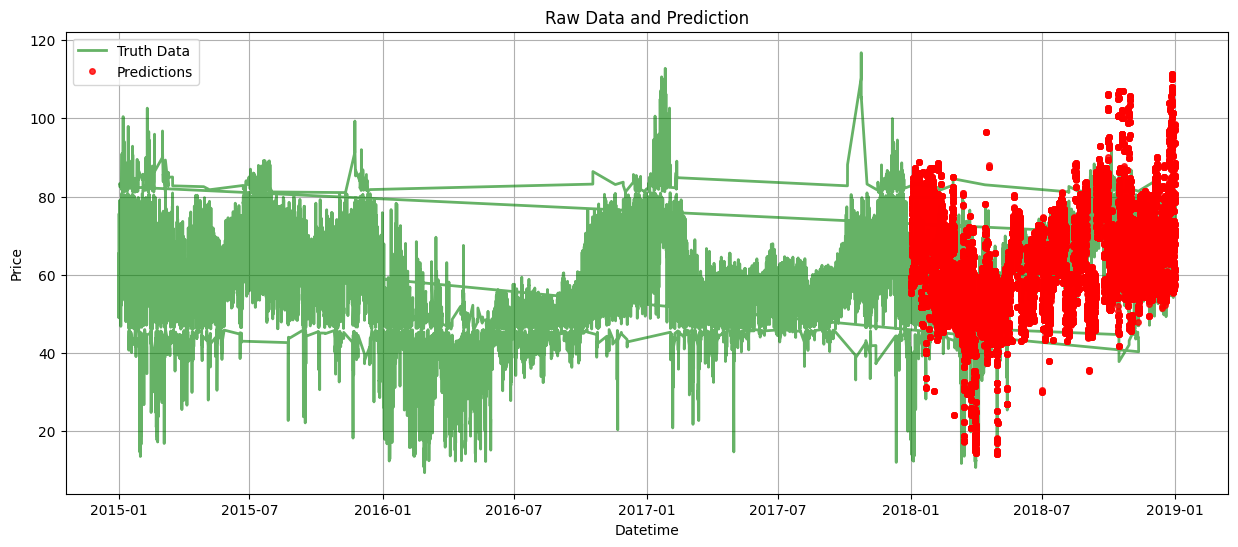

In [18]:
y_true = df['price actual']
dates = df.index 

plt.figure(figsize=(15, 6))

# Plot the actual values in blue with some transparency (alpha)
plt.plot(y_true.index, y_true.values, label='Truth Data', color='green', linewidth=2, alpha=0.6)

# Plot the predicted values in red with larger marker size
plt.plot(X_test.index, y_pred_rf, 'r.', label='Predictions', markersize=8, alpha=0.8)

# Add labels and title
plt.title('Raw Data and Prediction')
plt.xlabel('Datetime')
plt.ylabel('Price')

# Add grid for better readability
plt.grid(True)

# Add legend
plt.legend()

# Display the plot
plt.show()

### Training XGBoost Regressor 

In [14]:

# Define your XGBRegressor model
model_xgb = XGBRegressor()

# Define columns for one-hot encoding
cat_col = ['weather_main']

# Define columns for standardization
num_col = X_train.select_dtypes('number').columns.tolist()

# Define the pipeline for numerical features
num_pipe = Pipeline(steps=[
    ('scale', StandardScaler())
])

# Define the pipeline for categorical features
cat_pipe = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

# Combine the transformers in a ColumnTransformer
process = ColumnTransformer(transformers=[
    ('num_tran', num_pipe, num_col),
    ('cat_tran', cat_pipe, cat_col)
], remainder='passthrough')

# Create the final pipeline
final_xgb = Pipeline(steps=[
    ('process', process),
    ('model', model_xgb)
])

# Fit the final model
final_xgb.fit(X_train, y_train)

Pipeline(steps=[('process',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_tran',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['generation biomass',
                                                   'generation fossil brown '
                                                   'coal/lignite',
                                                   'generation fossil gas',
                                                   'generation fossil hard '
                                                   'coal',
                                                   'generation fossil oil',
                                                   'generation hydro pumped '
                                                   'storage consumption',
                                                   'generation hydro '
                                                   'run-of-river and p...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

### XG Boost Model Evaluation

In [15]:
y_pred_xgb = final_xgb.predict(X_test)
print(f"mean_absolute_error : {mean_absolute_error(y_test, y_pred_xgb):.2f}")
print(f"mean_squared_error : {mean_squared_error(y_test, y_pred_xgb):.2f}")
print(f"r2_score : {r2_score(y_test, y_pred_xgb):.2f}")


mean_absolute_error : 5.75
mean_squared_error : 75.23
r2_score : 0.49


### Forecast on Test

### Visualising forecasting for XGBoost Regressor model by plotting graph

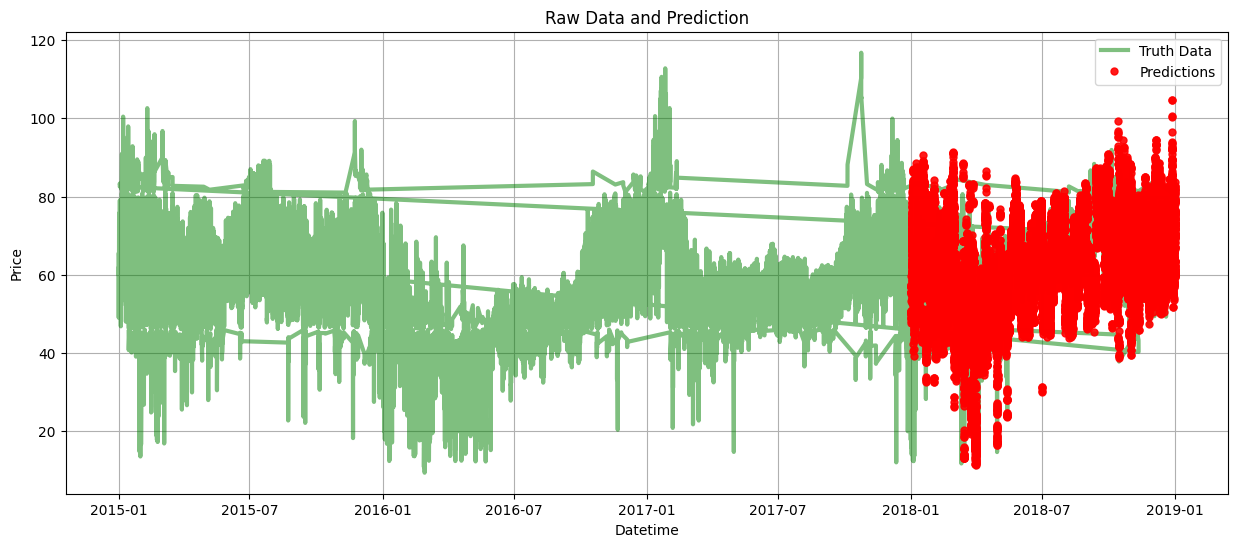

In [19]:
plt.figure(figsize=(15, 6))

# Plot the actual values in blue with transparency and slightly thicker line
plt.plot(y_true.index, y_true.values, label='Truth Data', color='green', linewidth=3, alpha=0.5)

# Plot the predicted values in red with larger marker size and a line
plt.plot(X_test.index, y_pred_xgb, 'r.', label='Predictions', markersize=10, alpha=0.9)


# Add labels and title
plt.title('Raw Data and Prediction')
plt.xlabel('Datetime')
plt.ylabel('Price')

# Add a grid for clarity
plt.grid(True)

# Add legend
plt.legend()

# Display the plot
plt.show()

### Getting importance of each features and storing them in a pandas Data frame

In [16]:
feature_names = process.get_feature_names_out()

# Get the feature importances from the model
# This is where the model must have already been fitted
model_xgb.fit(process.fit_transform(X_train), y_train)  # Fit the model to transformed data
feature_importances = model_xgb.feature_importances_

# Create a DataFrame to hold feature names and importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Set the index to feature names
importance_df.set_index('Feature', inplace=True)

# Sort the DataFrame by importance
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Display the feature importances DataFrame
print(importance_df)

                                                      Importance
Feature                                                         
num_tran__price day ahead                           4.535032e-01
num_tran__year                                      1.965632e-01
num_tran__month                                     7.168233e-02
num_tran__day                                       7.056305e-02
num_tran__hour                                      4.611610e-02
num_tran__total load actual                         1.896390e-02
num_tran__generation biomass                        1.298733e-02
num_tran__wind_speed                                1.003136e-02
num_tran__generation wind onshore                   9.144411e-03
num_tran__generation waste                          8.537181e-03
num_tran__generation fossil oil                     8.480547e-03
num_tran__total load forecast                       8.255851e-03
num_tran__generation fossil hard coal               8.055408e-03
num_tran__generation hydr

Overall Trend: The predicted values generally follow the overall trend of the true values, suggesting that the model has captured the long-term patterns in the data.

1. Short-Term Fluctuations: The model struggles to capture the short-term fluctuations and spikes in the true values. This indicates that the model might benefit from incorporating more features or adjusting hyperparameters to improve its ability to model local variations.
2. Prediction Intervals: While not explicitly shown in the plot, it would be helpful to visualize prediction intervals (e.g., 95% confidence intervals) to assess the uncertainty associated with the predictions. This would provide a better understanding of the model's reliability and potential errors.

### Potential Improvements:

1. Feature Engineering: Explore creating new features that might capture more relevant information, such as lagged values, seasonal components, or external factors that could influence price actual.
2. Hyperparameter Tuning: Experiment with different hyperparameters for the XGBoost model to optimize its performance. Techniques like grid search or random search can be used to find the best combination of hyperparameters.   
3. Ensemble Methods: Consider combining multiple models (e.g., using stacking or bagging) to improve prediction accuracy and reduce overfitting.
4. Time Series Analysis: If the data has a time component, explore time series-specific techniques like ARIMA or Prophet to capture temporal dependencies and seasonality.